# torch.Tensor.register_hook(hook)

功能：注册一个反向传播 hook 函数，这个函数是 Tensor 类里的，当计算 tensor 的梯度时自动执行。  
形式： hook(grad) -> Tensor or None ，其中 grad 就是这个 tensor 的梯度。  
返回值：a handle that can be used to remove the added hook by calling handle.remove()


## 例 1


In [ ]:
import torch
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)
a = torch.add(w, x)  # retain_grad()
b = torch.add(w, 1)
y = torch.mul(a, b)
a_grad = list()
# a,b因为不是叶子结点，梯度不会保存，除非retain_grad=True
# a.retain_grad()
# b.retain_grad()
# y不是叶子结点，也不会保存，如果retain_grad=True,则梯度永远是1
# y.retain_grad()


def grad_hook(grad):
    a_grad.append(grad)


handle = a.register_hook(grad_hook)
y.backward()
# 查看梯度
print("gradient:", w.grad, x.grad, a.grad, b.grad, y.grad)
print("a_grad[0]: ", a_grad[0])
handle.remove()

gradient: tensor([5.]) tensor([2.]) tensor([2.]) tensor([3.]) tensor([1.])
a_grad[0]:  tensor([2.])


## 例 2


In [ ]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)
a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)
a_grad = list()


def grad_hook(grad):
    grad *= 2

    # return grad*3
handle = w.register_hook(grad_hook)
y.backward()
# 查看梯度
print("w.grad: ", w.grad)
handle.remove()

w.grad:  tensor([10.])


# torch.nn.Module.register_forward_hook

功能：Module 前向传播中的 hook,module 在前向传播后，自动调用 hook 函数。  
形式：hook(module, input, output) -> None。注意不能修改 input 和 output 的返回值。
其中，module 是当前网络层，input 是网络层的输入数据, output 是网络层的输出数据

应用场景：如用于提取特征图  
举例：假设网络由卷积层 conv1 和池化层 pool1 构成，输入一张 4\*4 的图片，现采用 forward_hook 获取 module——conv1 之后的 feature maps，示意图如下：
![](hook-demo.png)


In [ ]:
import torch
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3)  # 输入通道数=1，输出通道数=2，卷积核大小=3×3
        self.pool1 = nn.MaxPool2d(2, 2)  # 2×2 池化

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        return x
# 这个 hook 的作用是 在 conv1 前向传播时，保存它的输入和输出数据，方便后续观察


def farward_hook(module, data_input, data_output):
    fmap_block.append(data_output)  # 记录特征图（输出）
    input_block.append(data_input)  # 记录输入


if __name__ == "__main__":
    # 初始化网络
    net = Net()
    with torch.no_grad():
        net.conv1.weight[0].fill_(1)  # 通道 0 的卷积核填充全 1
        net.conv1.weight[1].fill_(2)  # 通道 1 的卷积核填充全 2
    net.conv1.bias.data.zero_()   # 偏置项置 0
    # 注册hook
    fmap_block = list()
    input_block = list()
    net.conv1.register_forward_hook(farward_hook)
    # inference
    # 形状 (1, 1, 4, 4)：
# 1 是 batch_size（单个样本）
# 1 是通道数（单通道）
# 4x4 是输入图像的尺寸
# 值全为 1.，说明输入图像是一个全 1 的 4×4 图像。
    fake_img = torch.ones((1, 1, 4, 4))   # batch size * channel * H * W
    output = net(fake_img)
    # 观察
    # 形状 (1, 2, 2, 2)：
# 1 是 batch_size
# 2 是输出通道数（因为 conv1 设定了 out_channels=2）
# 2×2 是特征图的空间维度（从 4×4 变成 2×2）
    print("output shape: {}\noutput value: {}\n".format(output.shape, output))
    print("feature maps shape: {}\noutput value: {}\n".format(
        fmap_block[0].shape, fmap_block[0]))
    print("input shape: {}\ninput value: {}".format(
        input_block[0][0].shape, input_block[0]))

output shape: torch.Size([1, 2, 1, 1])
output value: tensor([[[[ 9.]],

         [[18.]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

feature maps shape: torch.Size([1, 2, 2, 2])
output value: tensor([[[[ 9.,  9.],
          [ 9.,  9.]],

         [[18., 18.],
          [18., 18.]]]], grad_fn=<ConvolutionBackward0>)

input shape: torch.Size([1, 1, 4, 4])
input value: (tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]]),)


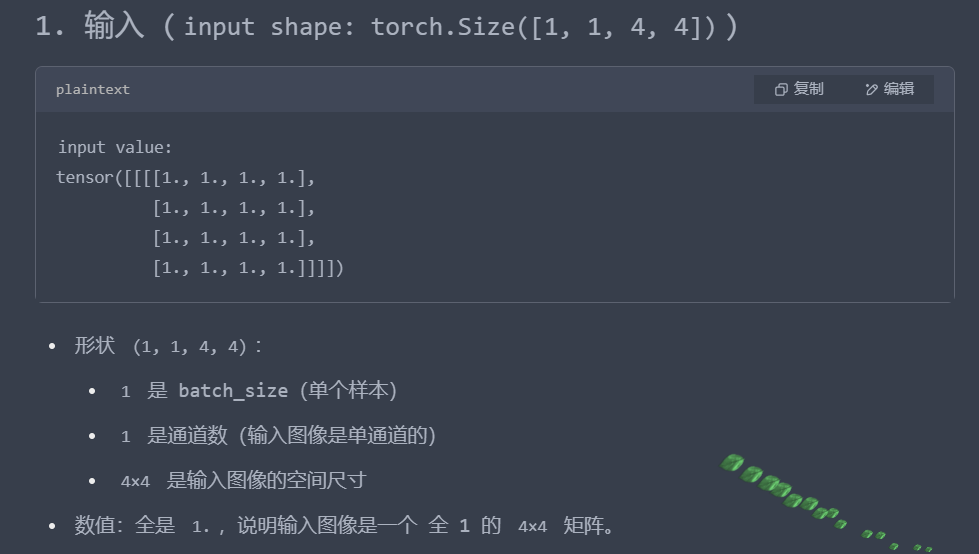


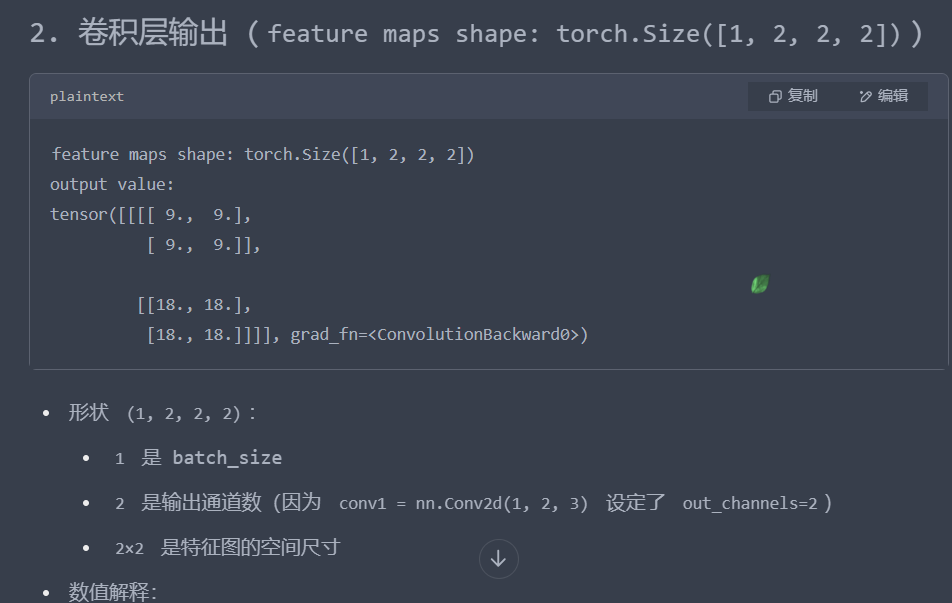


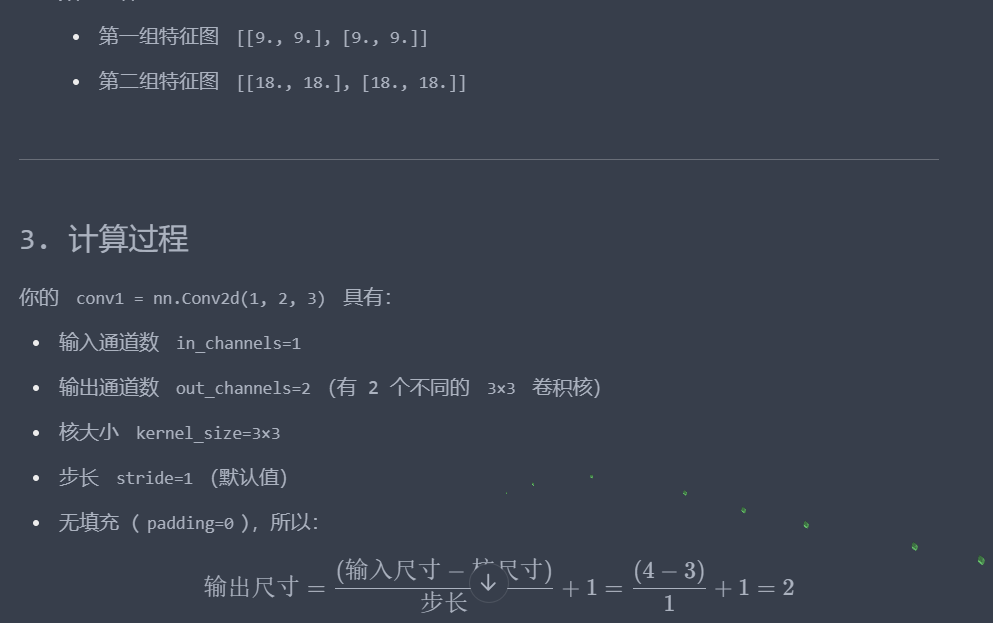


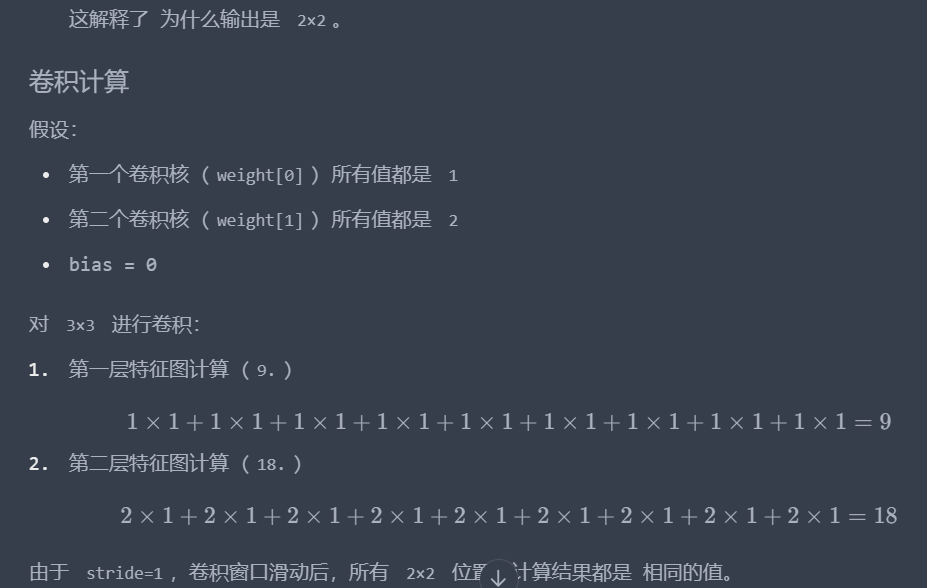


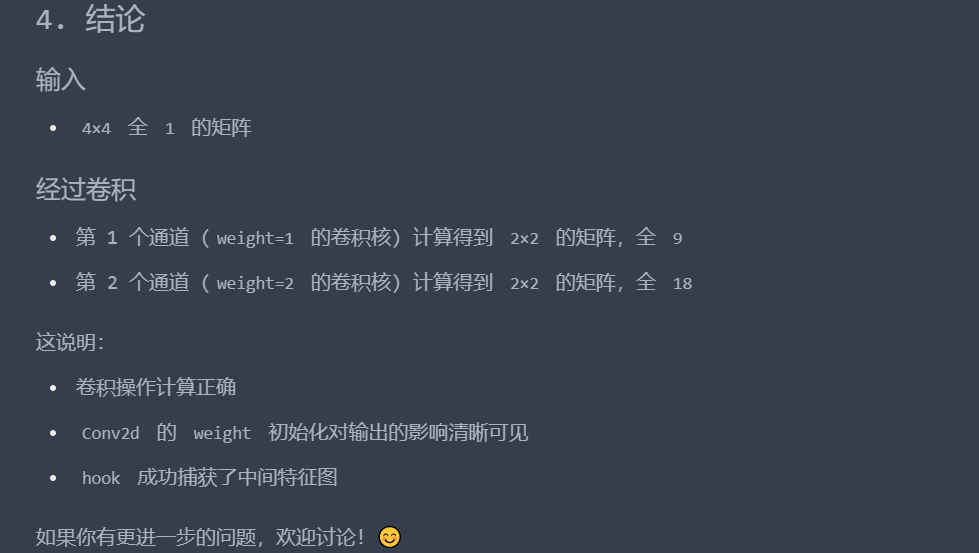
